<a href="https://colab.research.google.com/github/hariseldon99/msph402b/blob/main/Ordinary_Differential_Equations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

All Example Codes for Ordinary Differential Equations
===============================================

### Suggestion

Run the code cell below before the others to make sure that scipy is up to date and the figures render well.

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['font.size'] = 20
!pip3 install --upgrade scipy

**The Damped Harmonic Oscillator**

### The Problem

Use the $rk23$ (Second order Runge-Kutta) method and plot a solution $x(t)$ for the damped harmonic oscillator, described by the differential equations

\begin{equation}
\frac{d^2x}{dt^2} + \gamma\frac{dx}{dt} + x = 0.
\end{equation}

Also, obtain phase space plots for some values of $\gamma$.

We can recast the equation above in terms of the phase space point $y = \left[y_0, y_1\right] = \left[x, \dot{x}\right]$, yielding

\begin{align*}
\dot{y}_0 &= y_1\\
\dot{y}_1 &= -y_0 - \gamma y_1
\end{align*}

The code cell below has code that uses 'solve_ivp' routine in the 'scipy.integrate' module to solve the dynamics from $y_0=1, y_1=0$ at $t=0$. The next code cell plots the phase space, $y_1$ vs $y_0$, for a numpy grid of initial conditions.

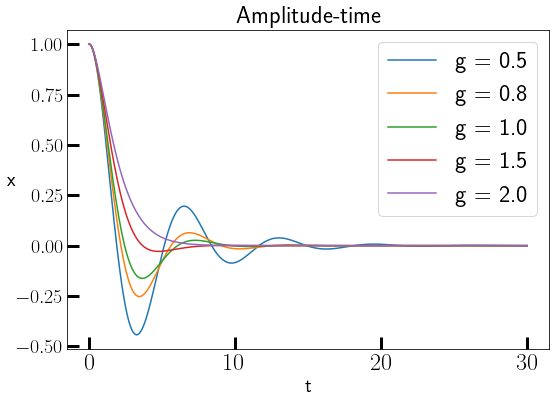

In [6]:
import numpy as np
from scipy.integrate import solve_ivp


def func(t, y, g):
    y0, y1 = y
    dy0dt = y1 
    dy1dt = -y0 - g * y1
    return np.array([dy0dt, dy1dt])


y_init = [1.0, 0.0]
t_final = 30
times = np.linspace(0.0, t_final, 1000)

plt.title("Amplitude-time")
plt.xlabel('t')
plt.ylabel('x', rotation=0)
gammas = [0.5, 0.8, 1.0, 1.5, 2.0]
for g in gammas:
    soln = solve_ivp(func, (0, t_final), y_init, t_eval=times, method='RK23',\
                     args=(g,))
    plt.plot(times, soln.y[0], label=f'g = {g:1.1f}')
    
plt.legend()   

plt.show()

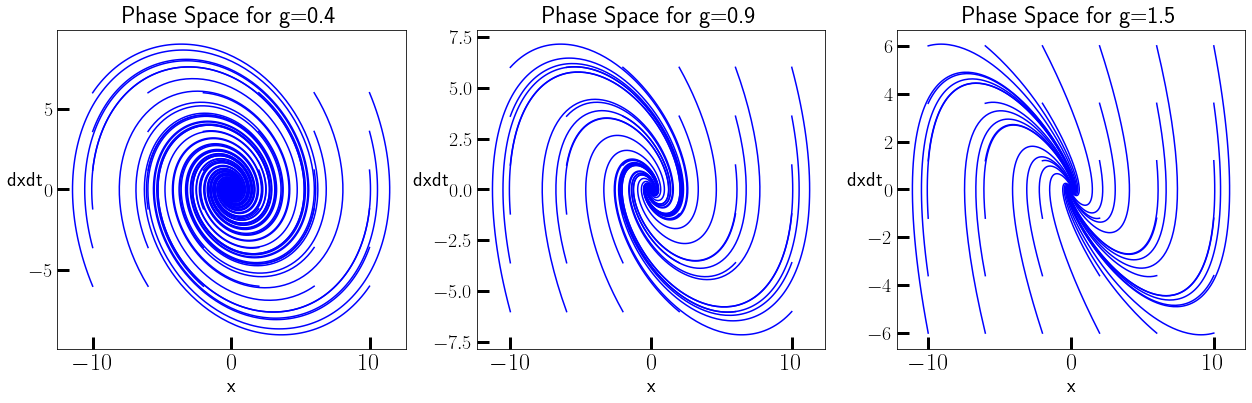

CPU times: user 1.29 s, sys: 18.5 ms, total: 1.31 s
Wall time: 1.33 s


In [8]:
%%time
import matplotlib.pyplot as plt
gammas = [0.4, 0.9, 1.5]
t_final = 30
times = np.linspace(0.0, t_final, 1000)

# Grid of initial conditions, recast as an iterable object 'ics'
y0m, y0mx = -10, 10
y1m, y1mx = -6, 6
Y0, Y1 = np.mgrid[y0m:y0mx:6j, y1m:y1mx:6j]
ics = np.vstack([Y0.ravel(), Y1.ravel()]).T

def func(t, y, g):
    y0, y1 = y
    dy0dt = y1 
    dy1dt = -y0 - g * y1
    return np.array([dy0dt, dy1dt])


plt.rcParams['figure.figsize'] = (len(gammas)*6,6)
for i,g in enumerate(gammas):
    plt.subplot(1,len(gammas),i+1)
    plt.title(f"Phase Space for g={g:1.1f}")
    plt.xlabel('x')
    plt.ylabel('dxdt', rotation=0)
    for p in ics:
        soln = solve_ivp(func, (0, t_final), p, t_eval=times, method='RK23',\
                         args=(g,))
        plt.plot(soln.y[0], soln.y[1], "b-")

plt.show()

**The Driven Oscillator with Damping**

### The Problem

Consider the previous problem, but add a forced external oscillation:

\begin{equation}
\frac{d^2x}{dt^2} + \gamma\frac{dx}{dt} + x = x_0\sin{\omega t}.
\end{equation}

We can recast the equation above in terms of the phase space point $y = \left[y_0, y_1\right] = \left[x, \dot{x}\right]$, yielding

\begin{align*}
\dot{y}_0 &= y_1\\
\dot{y}_1 &= -y_0 - \gamma y_1 + x_0\sin{\omega t}
\end{align*}

Use the general $rk45$ integrator to obtain plots of the amplitude as a function of time for different driving frequencies $\omega$. Plot the root mean-squared amplitude (taken over very long times) as a function of $\omega$ and show that there is a resonance. Compare the runtimes of a trial with the older $rk23$ method and the stiffness-detecting implicit $LSODA$ method, keeping the same error bounds for both. Finally, you can experiment with the driving term by replacing the sine wave with a square wave and see what happens.

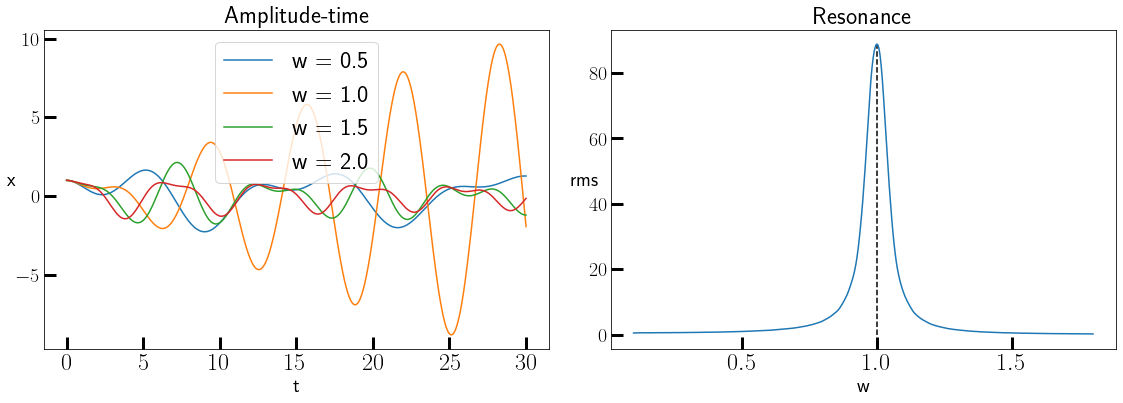

In [10]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16,6)
from scipy.integrate import solve_ivp
from scipy.signal import square

x0 = 1
g = 0.05
y_init = [1.0, 0.0]


def func(t, y, g, x0, w):
    y0, y1 = y
    dy0dt = y1 
    dy1dt = -y0 - g * y1 + x0 * np.sin(w * t)
    # dy1dt = -y0 - g * y1 + x0 * square(w * t)
    return np.array([dy0dt, dy1dt])


plt.subplot(1,2,1)
plt.title("Amplitude-time")
plt.xlabel('t')
plt.ylabel('x', rotation=0)
omegas = [0.5, 1.0, 1.5, 2.0]
t_final = 30
times = np.linspace(0.0, t_final, 1000)

for w in omegas:
    soln = solve_ivp(func, (0, t_final), y_init, t_eval=times, method='RK45',\
                     args=(g,x0, w))
    plt.plot(times, soln.y[0], label=f'w = {w:1.1f}')

plt.legend()

plt.subplot(1,2,2)
plt.title("Resonance")
plt.xlabel('w')
plt.ylabel('rms', rotation=0)

omegas = np.linspace(0.1, 1.8, 400)
rms = np.zeros_like(omegas)

t_final = 100
times = np.linspace(0.0, t_final, 4000)
for i,w in enumerate(omegas):
    soln = solve_ivp(func, (0, t_final), y_init, t_eval=times, method='RK45',\
                     args=(g,x0, w))
    rms[i] = np.average(np.abs(soln.y[0])**2) - np.average(soln.y[0])**2

plt.vlines(1.0, 0.0, np.amax(rms),colors='black', linestyles='dashed')
plt.plot(omegas, rms)
plt.show()

In [ ]:
x0 = 1
g = 0.05
y_init = [1.0, 0.0]
w = 0.6
t_final = 50
times = np.linspace(0, t_final, 1000)

print("Runtimes for rk23:")
%timeit soln = solve_ivp(func, (0, t_final), y_init, t_eval=times, method='RK23',\
                         args=(g,x0, w), rtol=1e-5, atol=1e-8)
print("\nRuntimes for rk45:")
%timeit soln = solve_ivp(func, (0, t_final), y_init, t_eval=times, method='RK45',\
                         args=(g,x0, w), rtol=1e-5, atol=1e-8)
print("\nRuntimes for lsoda:")
%timeit soln = solve_ivp(func, (0, t_final), y_init, t_eval=times, method='LSODA',\
                         args=(g,x0, w), rtol=1e-5, atol=1e-8)

Runtimes for rk23:
1 loop, best of 5: 223 ms per loop

Runtimes for rk45:
10 loops, best of 5: 120 ms per loop

Runtimes for lsoda:
10 loops, best of 5: 54.7 ms per loop


**Simulating Dynamics with Stiffness**

### The Problem:
An ordinary differential equation problem is stiff if the solution being sought is varying slowly, but there are nearby solutions that vary rapidly, so the numerical method must take small steps to obtain satisfactory results.

Stiffness is an efficiency issue. If we weren't concerned with how much time a computation takes, we wouldn't be concerned about stiffness. Nonstiff methods can solve stiff problems; they just take a long time to do it.

A model of flame propagation provides an example. When you light a match, the ball of flame grows rapidly until it reaches a critical size. Then it remains at that size because the amount of oxygen being consumed by the combustion in the interior of the ball balances the amount available through the surface. The simple model is

\begin{equation*}
\frac{dy}{dt} = y^2-y^3,
\end{equation*}

with initial condition $y(0)=\delta$, evolving for times $0<t<2/\delta$.

The scalar variable  $y(t)$ represents the radius of the ball. The  $y^2$ and  $y^3$  terms come from the surface area and the volume. The critical parameter is the initial radius, $\delta$ , which is "small." We seek the solution over a length of time that is inversely proportional to $\delta$.

We will start with the $RK45$ routine. If $\delta$ is not very small, the problem is not very stiff. Let us set  $\delta=0.01$  and request a relative error of $10^{-4}$ and see what we get.

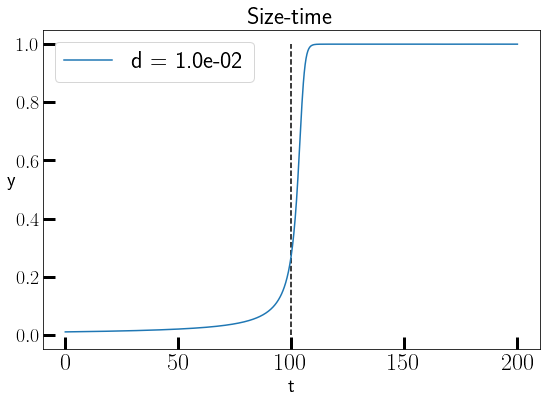

In [11]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8,6)

def radius(initsize, **kwargs):
    t_final = 2.0/initsize
    times = np.linspace(0.0, t_final, 1000)
    return solve_ivp(lambda t,y: y**2 * (1-y), (0, t_final), [initsize],\
                     t_eval=times, **kwargs)
    
d = 0.01
data = radius(d, method='RK45', rtol=1e-4)
plt.title("Size-time")
plt.xlabel('t')
plt.ylabel('y', rotation=0)
plt.plot(data.t, data.y[0], label=f'd = {d:1.1e}')
plt.vlines(1/d, 0.0, np.amax(data.y[0]),colors='black', linestyles='dashed')
plt.legend()   
plt.show()

Now let's see stiffness in action. Decrease $\delta$ by a couple of orders of magnitude and measure the execution time. Compare the execution times of $RK45$ with the stiffness-detecting $LSODA$ method for both the stiff and non-stiff cases.

#### Suggestion

To expedite the execution of the $LSODA$ algorithm, add a routine for computing the Jacobian of the RHS. In this particular case, the Jacobian is simply

\begin{equation*}
J = \frac{d}{dy}\left(y^2-y^3\right)=2y-3y^2
\end{equation*}

In [ ]:
print("Non-Stiff Case -")
d2 = 1e-1
print("RK45:")
%timeit radius(d2, method='RK45', rtol=1e-4)
print("LSODA:")
%timeit radius(d2, method='LSODA', rtol=1e-4)
print("\nStiff Case -")
d2 = 1e-4
print("RK45:")
%timeit radius(d2, method='RK45', rtol=1e-4)
print("LSODA sans Jacobian:")
%timeit radius(d2, method="LSODA", rtol=1e-4)
print("LSODA:")
%timeit radius(d2, method='LSODA', rtol=1e-4, jac=lambda t,y: y*(2-3*y))

Non-Stiff Case -
RK45:
100 loops, best of 5: 3.08 ms per loop
LSODA:
100 loops, best of 5: 3.09 ms per loop

Stiff Case -
RK45:
1 loop, best of 5: 404 ms per loop
LSODA sans Jacobian:
100 loops, best of 5: 5.98 ms per loop
LSODA:
100 loops, best of 5: 5.73 ms per loop


**Simulation of Non-Linear Dynamics Problems:**

### The Problem: The Van der Pol Oscillator
Van der Pol’s differential equation is

\begin{equation}
\frac{d^2x}{dt^2} - \mu\left(1-x^2\right)\frac{dx}{dt} + x = 0.
\end{equation}

The equation describes a system with nonlinear damping, the degree of nonlinearity given by $\mu$. If $\mu=0$, the system is linear and undamped, but as $\mu$ increases, so does the strength of the nonlinearity. 

Plot the phase portrait for the solution to Van der Pol’s equation in Python using SciPy’s ODE solver 'ivp_solve'.
We can recast the equation above in terms of the phase space point $y = \left[y_0, y_1\right] = \left[x, \dot{x}\right]$, yielding

\begin{align*}
\dot{y}_0 &= y_1\\
\dot{y}_1 &=  \mu\left(1-x^2\right) y_1 - y_0
\end{align*}

If $\mu=0$, we have a simple harmonic oscillator and the phase portrait is simply a circle. For larger values of $\mu$, the solutions enter limit cycles, but the cycles are more complicated than just circles. These lcycles are periodic attractors: every non-trivial solution converges to the limit cycle.

The code cell below yields the phase space plot.

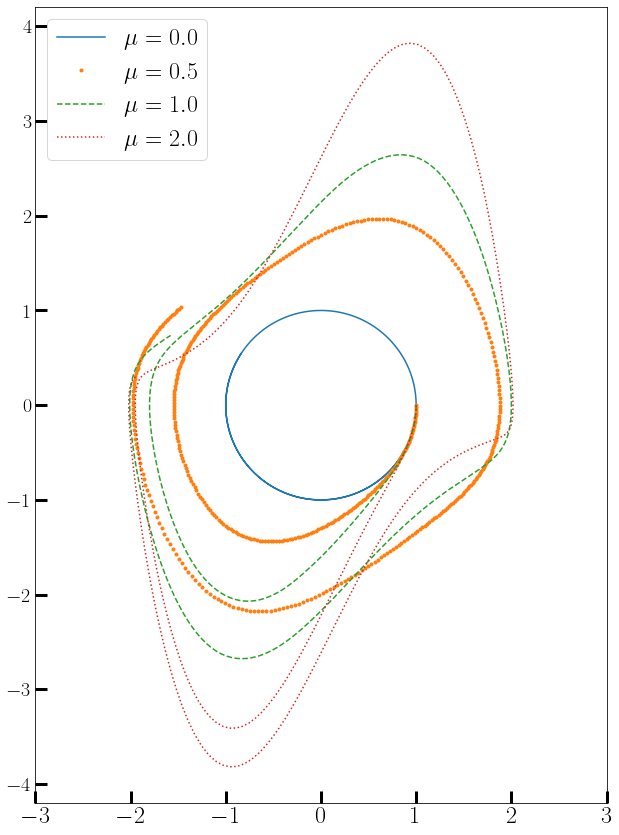

In [12]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (9,12)

def vdp(t, z):
    x, y = z
    return [y, mu*(1 - x**2)*y - x]

a, b = 0, 10

mus = [0, 0.5, 1, 2]
styles = ["-", ".", "--", ":"]
t = np.linspace(a, b, 500)

for mu, style in zip(mus, styles):
    sol = solve_ivp(vdp, [a, b], [1, 0], t_eval=t)
    plt.plot(sol.y[0], sol.y[1], style)
  
# make a little extra horizontal room for legend
plt.xlim([-3,3])    
plt.legend([f"$\mu={m:1.1f}$" for m in mus])
plt.show()

### The Problem: Limit Cycles in the Van der Pol Oscillator

A couple questions come to mind. First, how quickly do the solutions become periodic? Second, how does the period depend on $\mu$? To address these questions, we’ll use an optional argument to ivp_solve we have not used before.

For 'ivp_solve', an *event* is a function of the time $t$ and the solution $y$ whose roots the solver will report. To determine the period, we’ll look at where the solution is zero; our event function is trivial since we want to find the roots of the solution itself.

Since we have cast our second order ODE as a pair of first order ODEs, our solution is a vector, the function $x$ and its derivative. So to find roots of the solution, we look at what the solver sees as the first component of the solver. So, our 'event' function can simply be:

In [13]:
def root(t, y): return y[0]

Let’s set $\mu = 2$ and find the zeros of the solution over the interval $[0, 40]$, starting from the initial condition $x(0) = 1, \dot{x}(0) = 0$.

In [14]:
mu = 0.8
sol = solve_ivp(vdp, [0, 200], [1, 0], events=root)
zeros = sol.t_events[0]
print(zeros)

[  1.41013366   4.58431762   7.82882227  11.08463631  14.34102232
  17.59468017  20.85278725  24.11120772  27.36941157  30.62141203
  33.87377408  37.12589835  40.37807001  43.63023298  46.88239774
  50.13456216  53.38672665  56.63889113  59.8910556   63.14322008
  66.39538456  69.64754904  72.89971351  76.15187799  79.40404247
  82.65620694  85.90837142  89.1605359   92.41270037  95.66486485
  98.91702933 102.16919381 105.42135828 108.67352276 111.92568724
 115.17785171 118.43001619 121.68218067 124.93434515 128.18650962
 131.4386741  134.69083858 137.94300305 141.19516753 144.44733201
 147.69949648 150.95166096 154.20382544 157.45598992 160.70815439
 163.96031887 167.21248335 170.46464782 173.7168123  176.96897678
 180.22114126 183.47330573 186.72547021 189.97763469 193.22979916
 196.48196364 199.73412817]


To estimate the period of the limit cycle we look at the spacing between zeros, and how that spacing is changing. Finally, if we plot the deltas we see that the zero spacings quickly approach a constant value. Zero crossings are half periods, so the period of the limit cycle is twice the limiting spacing between zeros.

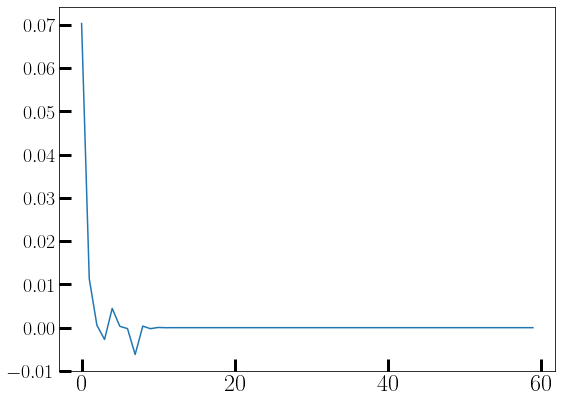

Time period of cycle for mu = 0.8 is 6.50


In [17]:
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8,6)

mu = 0.8

sol = solve_ivp(vdp, [0, 200], [1, 0], events=root)
zeros = sol.t_events[0]
spacing = zeros[1:] - zeros[:-1]
deltas = spacing[1:] - spacing[:-1]
plt.plot(deltas)
plt.show()
print(f"Time period of cycle for mu = {mu:2.1f} is {2 * spacing[-1]:2.2f}")

### Homework

As homework, the student is encouraged to determine the following numerically:

* Formulate and execute a Python program for estimating the period of the limit cycle of a Van der Pol oscillator for a given value of $\mu$. Plot the period as a function of $\mu$

* Run this program for small $\mu$ and large $\mu\sim 100$. The method described above should fail for large $\mu$. Plot $x$ vs $t$ for large $\mu$ and explain why it fails.

* Consider the previous Van der Pol oscillator problem, but now with a drive $F(t) = \cos{\left(2\pi t/T\right)}$. Plot the phase space for $T=10$ and $\mu=9$. Explain the changes that take place as you vary $\mu$ keeping $T$ fixed.

### The Problem: The Lorenz Attractor

The Lorenz system of coupled, ordinary, first-order differential equations have chaotic solutions for certain parameter values $\sigma, \rho$ and $\beta$ and initial conditions, $u(0), v(0)$ and $w(0)$. Note that this system is *dissipative*.

\begin{aligned}
\frac{\mathrm{d} u}{\mathrm{~d} t} &=\sigma(v-u) \\
\frac{\mathrm{d} v}{\mathrm{~d} t} &=\rho u-v-u w \\
\frac{\mathrm{d} w}{\mathrm{~d} t} &=u v-\beta w
\end{aligned}

The following program plots the Lorenz attractor (the values of $x, y$ and $z$ as a parametric function of time) on a Matplotlib 3D projection.

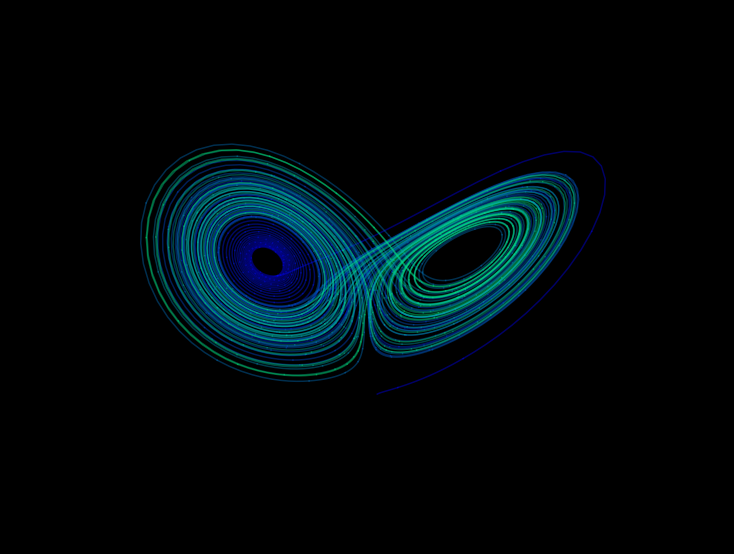

In [44]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

WIDTH, HEIGHT, DPI = 1000, 750, 100

# Lorenz paramters and initial conditions.
sigma, beta, rho = 10, 2.667, 28
u0, v0, w0 = 1, 1, 1

# Maximum time point and total number of time points.
tmax, n = 100, 10000

def lorenz(t, X, sigma, beta, rho):
    """The Lorenz equations."""
    u, v, w = X
    up = -sigma*(u - v)
    vp = rho*u - v - u*w
    wp = -beta*w + u*v
    return up, vp, wp

# Integrate the Lorenz equations.
soln = solve_ivp(lorenz, (0, tmax), (u0, v0, w0), args=(sigma, beta, rho),
                 dense_output=True)
# Interpolate solution onto the time grid, t.
t = np.linspace(0, tmax, n)
x, y, z = soln.sol(t)

# Plot the Lorenz attractor using a Matplotlib 3D projection.
fig = plt.figure(facecolor='k', figsize=(WIDTH/DPI, HEIGHT/DPI))
ax = fig.gca(projection='3d')
ax.set_facecolor('k')
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# Make the line multi-coloured by plotting it in segments of length s which
# change in colour across the whole time series.
s = 10
cmap = plt.cm.winter
for i in range(0,n-s,s):
    ax.plot(x[i:i+s+1], y[i:i+s+1], z[i:i+s+1], color=cmap(i/n), alpha=0.4)

# Remove all the axis clutter, leaving just the curve.
ax.set_axis_off()

plt.show()

### Homework

Play with the parameters of the Lorentz system in the code cell above and verify the following facts

* If $\rho <1$, then there is only one equilibrium point, which is at the origin. All orbits converge to the origin, which is a global attractor.

* A pitchfork bifurcation occurs at $\rho = 1$, and for $\rho > 1$, two additional critical points appear at $\left( \sqrt{\beta(\rho-1)}, \sqrt{\beta(\rho-1)}, \rho-1 \right)$ and $\left( -\sqrt{\beta(\rho-1)}, -\sqrt{\beta(\rho-1)}, \rho-1 \right)$ 
These correspond to steady convection. This pair of equilibrium points is stable only if the following criterion is met

\begin{equation*}
\rho < \sigma\frac{\sigma+\beta+3}{\sigma-\beta-1},\;\sigma > \beta+1
\end{equation*}

* At the critical value, both equilibrium points lose stability through a subcritical Hopf bifurcation.

As a solved example, we can see the onset of chaos in the Lorenz system by the sensitive dependence on initial conditions. The code cell below plots the same Lorenz system for two initial conditions that are only different by $2$ in $x$. The two trajectories are plotted in different colours. Initially, both trajectories nearly overlap. However, after some time, the two trajectories are easily distinguishable by two different colours that can be found in vastly separated regions.


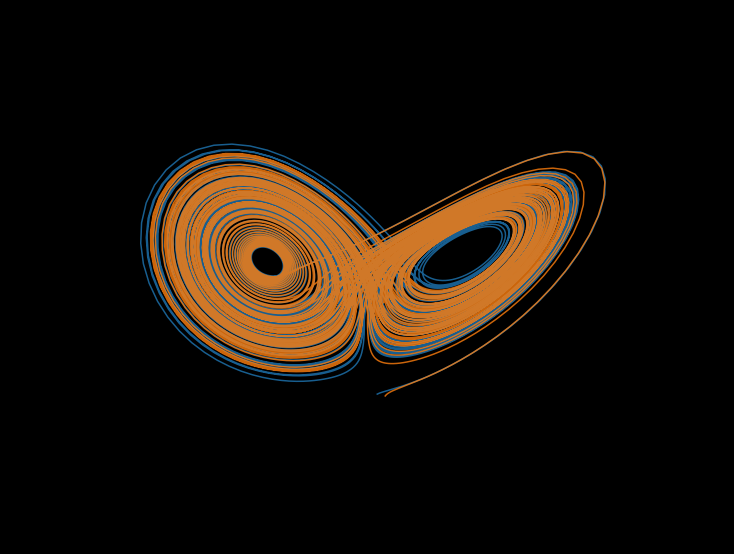

In [46]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

WIDTH, HEIGHT, DPI = 1000, 750, 100

# Lorenz paramters and initial conditions, apart from the one we're iterating.
sigma, beta, rho = 10, 2.667, 28
v0, w0 = 1, 1

# Maximum time point and total number of time points.
tmax, n = 100, 10000

fig = plt.figure(facecolor='k', figsize=(WIDTH/DPI, HEIGHT/DPI))
ax = fig.gca(projection='3d')
ax.set_facecolor('k')
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

us = [1, 2]
for i,u0 in enumerate(us):
  # Integrate the Lorenz equations.
  soln = solve_ivp(lorenz, (0, tmax), (u0, v0, w0), args=(sigma, beta, rho),
                   dense_output=True)
  # Interpolate solution onto the time grid, t.
  t = np.linspace(0, tmax, n)
  x, y, z = soln.sol(t)
  ax.plot(x,y,z, alpha=0.8)

# Remove all the axis clutter, leaving just the curve.
ax.set_axis_off()

plt.show()

### The Problem: The Henon-Heiles System

The Henon-Heiles system is a paradigmatic example of *Hamiltonian Chaos*, where chaos can occur in a completely conserved dynamical system. The system arises from the motion of stars around a galactic center, assuming the motion is restricted to the $xy$ plane.

The Hamiltonian is given for a two-dimensional dynamical system as

\begin{equation*}
H = \frac12 (p_x^2 + p_y^2) + \frac12(x^2 + y^2) +  \left(x^2y - \frac{y^3}{3}\right)
\end{equation*}

Thus, the ordinary differential equations that describe the dynamical evolution can be obtained from hamilton's equations of motion, yielding

\begin{align*}
\dot{x} &= p_x, \\
\dot{p}_x &= -x - 2 xy, \\
\dot{y} &= p_y, \\
\dot{p}_y &= -y - \left(x^2 - y^2\right).
\end{align*}

Let us define $u = [u_0, u_1, u_2, u_3] = [x,p_x,y,p_y]$. The only parameter of interest is the total energy $E$, for which a large number of initial conditions can be chosen, all of which satisfy
\begin{equation*}
E = \frac12 (u^2_1 + u^2_3) + \frac12(u^2_0 + u^2_2) +  \left(u^2_0u_2 - \frac{u^3_2}{3}\right)
\end{equation*}

While the dynamics can be readily simulated with the tools at our disposal, it cannot be plotted completely, as the phase space is $4-$dimensional. However, we can look at *Poincare Sections*, $2-$d cross-sections of the phase space obtained by strobing the trajectories at the times when they pass through the surface. Let us look for values of $(y, p_y)$, or $(u_2, u_3)$ whenever $u_0=0$ and $u_1>0$ during the evolution of every trajectory. Note that, since the energy is always supposed to be conserved, fixing $u_2, u_3$ and $u_0$ automatically yields only two solutions for $u_1$ from the energy equation above, and we can choose either one. We have chosen the positive ones, given by the following equation on the $u_0=0$ hypersurface.
\begin{equation*}
u_1 = \sqrt{2E - u^2_2\left(1-\frac{2}{3}u_2\right)-u^2_3}.
\end{equation*}

The code cell below plots Poincare Sections for trajectories for any energy. The following energies are suggested. 

| E =	| 1/50 	| 1/23 	| 1/15 	| 1/8 	| 1/6 	|
|---	|---	|---	|---	|---	|---	|

For each energy, a numpy mgrid of initial conditions are created and the dynamics evolved using the 'solve_ivp' routine, and the only times of interest are when $u_0=0$, which is encapsulated into an event function. The highest energies will cause transitions to chaos.

<timed exec>:30: RuntimeWarning: invalid value encountered in sqrt


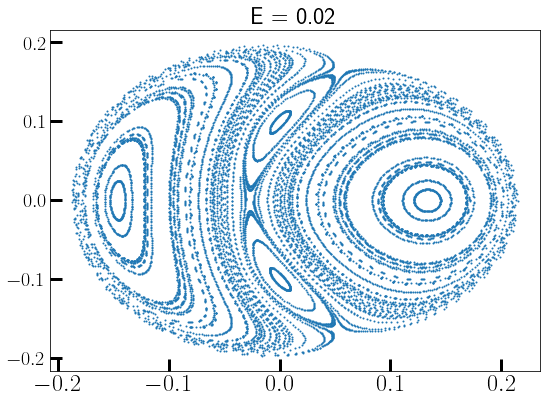

CPU times: user 38 s, sys: 15.5 ms, total: 38 s
Wall time: 38.1 s


In [21]:
%%time
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['font.size'] = 20

def henon_system(t, u): # right-hand side of a system of ODEs
    x = u[0]
    px = u[1]
    y  = u[2]
    py = u[3]
    return np.array([px, -x-2*x*y, py, -y-x**2+y**2])

def poincare(f, X0, epoch_n, h=0.001, N=10):
    t = h*N*epoch_n
    X = []
    for state0 in X0:
        u1, u2, u3 = state0
        sol = solve_ivp(f, [0, t], [0, u1, u2, u3], max_step=0.1, events=lambda t,u:u[0])
        X.append(sol.y_events[0])
    return X

def give_ics(En, min, max,npts):
  """
  Returns a grid of initial conditions, recast as an iterable object 'ics'
  """
  u2m, u2mx = min, max
  u3m, u3mx = min, max
  U2, U3 = np.meshgrid(np.linspace(u2m, u2mx, npts), np.linspace(u3m, u3mx, npts))
  u2, u3 = U2.ravel(), U3.ravel()
  u1 = np.sqrt(2 * En - u2**2  * (1 - (2/3) * u2) - u3**2)
  U1 = u1.reshape(U2.shape)
  ics = np.vstack([U1.ravel(), U2.ravel(), U3.ravel()]).T
  ics = ics[~np.isnan(ics).any(axis=1)] # Remove all points that lie outside the energy hypersurface
  return ics

if __name__ == "__main__":
  energy = 1.0/50.0
  X0_henon = give_ics(energy, -1.5, 0.0, 50)
  data = poincare(henon_system, X0_henon, epoch_n=10000, h=0.1, N=1)
  data =np.array(np.concatenate(data).ravel())
  u2 = data[2::4]
  u3 = data[3::4]
  plt.title(f"E = {energy:1.2f}")
  plt.scatter(u2, u3, s=1)
  plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in sqrt


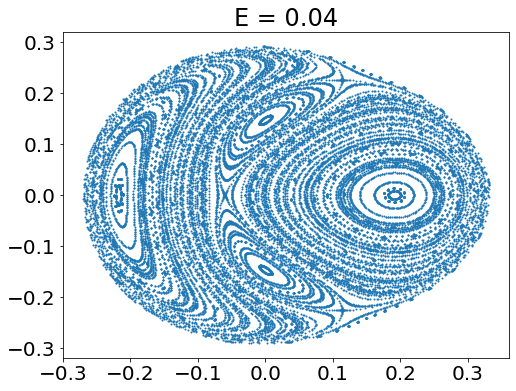

CPU times: user 1min 42s, sys: 596 ms, total: 1min 43s
Wall time: 1min 43s


In [41]:
%%time
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['font.size'] = 20

energy = 1.0/23.0
X0_henon = give_ics(energy, -1.5, 0.0, 50)
data = poincare(henon_system, X0_henon, epoch_n=10000, h=0.1, N=1)
data = np.array(np.concatenate(data).ravel())
u2 = data[2::4]
u3 = data[3::4]
plt.title(f"E = {energy:1.2f}")
plt.scatter(u2, u3, s=1)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in sqrt


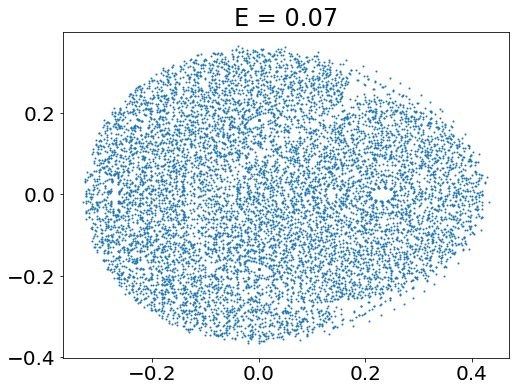

CPU times: user 40.1 s, sys: 278 ms, total: 40.4 s
Wall time: 40.5 s


In [43]:
%%time
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['font.size'] = 20

energy = 1.0/15.0
X0_henon = give_ics(energy, -1.5, 0.0, 75)
data = poincare(henon_system, X0_henon, epoch_n=1200, h=0.1, N=1)
data = np.array(np.concatenate(data).ravel())
u2 = data[2::4]
u3 = data[3::4]
plt.title(f"E = {energy:1.2f}")
plt.scatter(u2, u3, s=1)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in sqrt


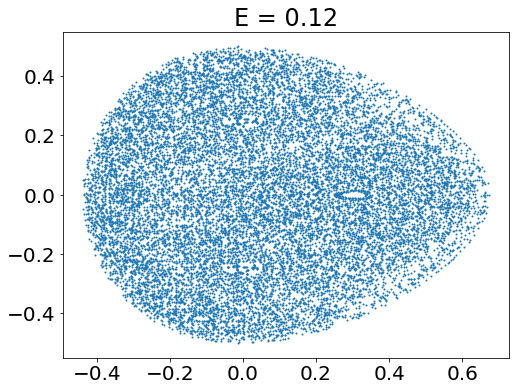

CPU times: user 1min 11s, sys: 353 ms, total: 1min 12s
Wall time: 1min 12s


In [36]:
%%time
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['font.size'] = 20

energy = 1.0/8.0
X0_henon = give_ics(energy, -1.5, 0.0, 75)
data = poincare(henon_system, X0_henon, epoch_n=1200, h=0.1, N=1)
data = np.array(np.concatenate(data).ravel())
u2 = data[2::4]
u3 = data[3::4]
plt.title(f"E = {energy:1.2f}")
plt.scatter(u2, u3, s=1)
plt.show()